In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import sys
import os
from pathlib import Path

os.chdir(path="/Research")
print(Path.cwd())
sys.path.append(os.path.abspath('/Research/gpudrive'))

from gpudrive.env.config import EnvConfig, SceneConfig
from gpudrive.env.env_torch import GPUDriveTorchEnv
from gpudrive.visualize.utils import img_from_fig
from gpudrive.env.dataset import SceneDataLoader

/Research


In [2]:

DYNAMICS_MODEL = "delta_local" # "delta_local" / "state" / "classic"
DATA_PATH = "data/processed/examples" # Your data path
MAX_NUM_OBJECTS = 64
NUM_ENVS = 2
DEVICE = "cuda:0"

# Configs
env_config = EnvConfig(dynamics_model=DYNAMICS_MODEL)

In [ ]:
# Make dataloader
data_loader = SceneDataLoader(
    root="gpudrive/data/processed/examples", # Path to the dataset
    batch_size=NUM_ENVS, # Batch size, you want this to be equal to the number of worlds (envs) so that every world receives a different scene
    dataset_size=NUM_ENVS, # Total number of different scenes we want to use
    sample_with_replacement=False, 
    seed=42, 
    shuffle=True,   
)

print("Making the environment")

# Make environment
env = GPUDriveTorchEnv(
    config=env_config,
    data_loader=data_loader,
    max_cont_agents=MAX_NUM_OBJECTS, # Maximum number of agents to control per scenario
    device="cuda", 
    action_type="continuous" # "continuous" or "discrete"
)

Making the environment
Compiling GPU engine code:
/Research/gpudrive/external/madrona/src/mw/device/memory.cpp
/Research/gpudrive/external/madrona/src/mw/device/state.cpp
/Research/gpudrive/external/madrona/src/mw/device/crash.cpp
/Research/gpudrive/external/madrona/src/mw/device/consts.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph.cpp
/Research/gpudrive/external/madrona/src/mw/device/taskgraph_utils.cpp
/Research/gpudrive/external/madrona/src/mw/device/sort_archetype.cpp
/Research/gpudrive/external/madrona/src/mw/device/host_print.cpp
/Research/gpudrive/external/madrona/src/mw/../common/hashmap.cpp
/Research/gpudrive/external/madrona/src/mw/../common/navmesh.cpp
/Research/gpudrive/external/madrona/src/mw/../core/base.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/physics.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/geo.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/xpbd.cpp
/Research/gpudrive/external/madrona/src/mw/../physics/tgs.c

/Research/gpudrive/src/level_gen.cpp(283): warning #177-D: function "madrona_gpudrive::createFloorPlane" was declared but never referenced
  static void createFloorPlane(Engine &ctx)
              ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"





In [ ]:
import importlib
import waymo_iterator
importlib.reload(waymo_iterator)
from waymo_iterator import TrajectoryIterator
from torch.utils.data import DataLoader

traj_data_loader = TrajectoryIterator(env, data_loader)
train_iterator = iter(DataLoader(traj_data_loader, batch_size=NUM_ENVS))

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.distributions.categorical import Categorical
    

In [6]:
import logging

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, output_size),
        )
        self.mean_head = nn.Linear(hidden_size, output_size)       # Output: 3 means (mu)
        self.log_std = nn.Parameter(torch.ones(output_size) * 0.5, requires_grad=True)    # Output: 3 log-stds (log(sigma))

    def dist(self, obs):
        """Generate action distribution."""
        x_out = self.nn(obs.float())
        means = self.mean_head(x_out)        # shape: [batch_size, 3]
        stds = torch.exp(self.log_std)           # enforce positive std

        # Create independent normal distributions for each dimension
        dist = torch.distributions.Normal(loc=means, scale=stds)
        return dist

    def forward(self, obs, deterministic=False):
        """Generate an output from tensor input."""
        return self.nn(obs), None
    
    def log_prob(self, dist, expert_actions):
        # logging.info(f"Log prob sum: {dist.log_prob(expert_actions).sum(dim=-1)}"); 
        # logging.info(f"Log prob : {dist.log_prob(expert_actions).sum(dim=-1)}, STD: {dist.stddev}")
        return dist.log_prob(expert_actions).sum(dim=-1)
    
    def entropy(self, dist): 
        # logging.info(f"Entropy : {dist.entropy()}, {dist.stddev}")
        return dist.entropy().sum(dim=-1)

In [8]:
DEVICE = "cuda:0"
bc_policy = Net(
    input_size=traj_data_loader.observation_space.shape[0], 
    hidden_size=800, 
    output_size=len(traj_data_loader.action_space)
).to(DEVICE)


In [ ]:
optimizer = Adam(bc_policy.parameters(), lr=1e-4)

EPOCHS = 1000
MINIBATCHES = 20

loss_fn = nn.MSELoss()
global_step = 0
for epoch in range(EPOCHS):    
    for i in range(MINIBATCHES): 
        # Get batch of obs-act pairs
        obs, expert_action, _, _ = next(train_iterator)
        obs, expert_action = obs.to(DEVICE), expert_action.to(DEVICE)
        
        act, _ = bc_policy(obs)
        loss = loss_fn(act, expert_action)
        # loss = -bc_policy._log_prob(obs, expert_action)

        # logging.info(f"Action: {act}, Expert: {expert_action}")

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
        # with torch.no_grad():
        #     pred_action = bc_policy(obs, deterministic=True)
        #     accuracy = (expert_action == pred_action).sum() / expert_action.shape[0]        
        
        logging.info(f"Epoch {epoch}, Iteration {i}, Loss: {loss.item()}")
        
        global_step += 1

INFO:root:Epoch 0, Iteration 0, Loss: 0.21261464059352875
INFO:root:Epoch 0, Iteration 1, Loss: 0.004655941389501095
INFO:root:Epoch 0, Iteration 2, Loss: 0.11893200874328613
INFO:root:Epoch 0, Iteration 3, Loss: 0.06552360951900482
INFO:root:Epoch 0, Iteration 4, Loss: 0.0490642786026001
INFO:root:Epoch 0, Iteration 5, Loss: 0.09388645738363266
INFO:root:Epoch 0, Iteration 6, Loss: 0.0669296383857727
INFO:root:Epoch 0, Iteration 7, Loss: 0.08734991401433945
INFO:root:Epoch 0, Iteration 8, Loss: 0.008084803819656372
INFO:root:Epoch 0, Iteration 9, Loss: 0.06285807490348816
INFO:root:Epoch 0, Iteration 10, Loss: 0.058448269963264465
INFO:root:Epoch 0, Iteration 11, Loss: 0.005122079513967037
INFO:root:Epoch 0, Iteration 12, Loss: 0.04994998499751091
INFO:root:Epoch 0, Iteration 13, Loss: 0.011930033564567566
INFO:root:Epoch 0, Iteration 14, Loss: 0.03835517168045044
INFO:root:Epoch 0, Iteration 15, Loss: 0.0031461743637919426
INFO:root:Epoch 0, Iteration 16, Loss: 0.09077668190002441
IN

Number of time steps: 91


INFO:root:Epoch 10, Iteration 14, Loss: 0.011461950838565826
INFO:root:Epoch 10, Iteration 15, Loss: 0.17155995965003967
INFO:root:Epoch 10, Iteration 16, Loss: 0.010914398357272148
INFO:root:Epoch 10, Iteration 17, Loss: 0.014015287160873413
INFO:root:Epoch 10, Iteration 18, Loss: 0.12152447551488876
INFO:root:Epoch 10, Iteration 19, Loss: 0.02472730353474617
INFO:root:Epoch 11, Iteration 0, Loss: 0.001181743573397398
INFO:root:Epoch 11, Iteration 1, Loss: 0.04487522691488266
INFO:root:Epoch 11, Iteration 2, Loss: 0.08065465092658997
INFO:root:Epoch 11, Iteration 3, Loss: 0.0038893844466656446
INFO:root:Epoch 11, Iteration 4, Loss: 0.04009323567152023
INFO:root:Epoch 11, Iteration 5, Loss: 0.01400832086801529
INFO:root:Epoch 11, Iteration 6, Loss: 0.05775175616145134
INFO:root:Epoch 11, Iteration 7, Loss: 0.008952463045716286
INFO:root:Epoch 11, Iteration 8, Loss: 0.018661856651306152
INFO:root:Epoch 11, Iteration 9, Loss: 0.010714216157793999
INFO:root:Epoch 11, Iteration 10, Loss: 0

Number of time steps: 91


INFO:root:Epoch 27, Iteration 18, Loss: 0.0002956614480353892
INFO:root:Epoch 27, Iteration 19, Loss: 0.004986258689314127
INFO:root:Epoch 28, Iteration 0, Loss: 0.003183303866535425
INFO:root:Epoch 28, Iteration 1, Loss: 0.01290074735879898
INFO:root:Epoch 28, Iteration 2, Loss: 0.00592085113748908
INFO:root:Epoch 28, Iteration 3, Loss: 0.011487222276628017
INFO:root:Epoch 28, Iteration 4, Loss: 0.001413064543157816
INFO:root:Epoch 28, Iteration 5, Loss: 0.006483105942606926
INFO:root:Epoch 28, Iteration 6, Loss: 0.007910557091236115
INFO:root:Epoch 28, Iteration 7, Loss: 0.002314580138772726
INFO:root:Epoch 28, Iteration 8, Loss: 0.0039717331528663635
INFO:root:Epoch 28, Iteration 9, Loss: 0.0017601896543055773
INFO:root:Epoch 28, Iteration 10, Loss: 0.00428597629070282
INFO:root:Epoch 28, Iteration 11, Loss: 0.0010555805638432503
INFO:root:Epoch 28, Iteration 12, Loss: 0.0021846590097993612
INFO:root:Epoch 28, Iteration 13, Loss: 0.003981468267738819
INFO:root:Epoch 28, Iteration 14

Number of time steps: 91


INFO:root:Epoch 45, Iteration 2, Loss: 0.00013718463014811277
INFO:root:Epoch 45, Iteration 3, Loss: 0.015769267454743385
INFO:root:Epoch 45, Iteration 4, Loss: 0.0010807565413415432
INFO:root:Epoch 45, Iteration 5, Loss: 0.008280173875391483
INFO:root:Epoch 45, Iteration 6, Loss: 0.0022024712525308132
INFO:root:Epoch 45, Iteration 7, Loss: 0.010351629927754402
INFO:root:Epoch 45, Iteration 8, Loss: 0.001941503374837339
INFO:root:Epoch 45, Iteration 9, Loss: 0.0014811772853136063
INFO:root:Epoch 45, Iteration 10, Loss: 0.002876847516745329
INFO:root:Epoch 45, Iteration 11, Loss: 0.004997556563466787
INFO:root:Epoch 45, Iteration 12, Loss: 0.0006831149803474545
INFO:root:Epoch 45, Iteration 13, Loss: 0.0021671587601304054
INFO:root:Epoch 45, Iteration 14, Loss: 0.0017978077521547675
INFO:root:Epoch 45, Iteration 15, Loss: 0.0016291846986860037
INFO:root:Epoch 45, Iteration 16, Loss: 0.0009434386156499386
INFO:root:Epoch 45, Iteration 17, Loss: 0.0014657846186310053
INFO:root:Epoch 45, I

Number of time steps: 91


INFO:root:Epoch 62, Iteration 6, Loss: 0.0014588203048333526
INFO:root:Epoch 62, Iteration 7, Loss: 0.01112292893230915
INFO:root:Epoch 62, Iteration 8, Loss: 0.0007224419387057424
INFO:root:Epoch 62, Iteration 9, Loss: 0.005819463171064854
INFO:root:Epoch 62, Iteration 10, Loss: 0.0030090860091149807
INFO:root:Epoch 62, Iteration 11, Loss: 0.0046014683321118355
INFO:root:Epoch 62, Iteration 12, Loss: 0.0015819313703104854
INFO:root:Epoch 62, Iteration 13, Loss: 0.0011495653307065368
INFO:root:Epoch 62, Iteration 14, Loss: 0.0012597899185493588
INFO:root:Epoch 62, Iteration 15, Loss: 0.0089553352445364
INFO:root:Epoch 62, Iteration 16, Loss: 0.0011074021458625793
INFO:root:Epoch 62, Iteration 17, Loss: 0.004867959301918745
INFO:root:Epoch 62, Iteration 18, Loss: 0.0019366333726793528
INFO:root:Epoch 62, Iteration 19, Loss: 0.001590152271091938
INFO:root:Epoch 63, Iteration 0, Loss: 0.0001769430236890912
INFO:root:Epoch 63, Iteration 1, Loss: 0.0011937618255615234
INFO:root:Epoch 63, It

Number of time steps: 91


INFO:root:Epoch 79, Iteration 10, Loss: 0.002185369376093149
INFO:root:Epoch 79, Iteration 11, Loss: 0.005427881609648466
INFO:root:Epoch 79, Iteration 12, Loss: 0.00046310023753903806
INFO:root:Epoch 79, Iteration 13, Loss: 0.003624536795541644
INFO:root:Epoch 79, Iteration 14, Loss: 0.0027347865980118513
INFO:root:Epoch 79, Iteration 15, Loss: 0.002578265964984894
INFO:root:Epoch 79, Iteration 16, Loss: 0.0010447029490023851
INFO:root:Epoch 79, Iteration 17, Loss: 0.0022962794173508883
INFO:root:Epoch 79, Iteration 18, Loss: 0.0010121073573827744
INFO:root:Epoch 79, Iteration 19, Loss: 0.008417245000600815
INFO:root:Epoch 80, Iteration 0, Loss: 0.0017390437424182892
INFO:root:Epoch 80, Iteration 1, Loss: 0.004645816050469875
INFO:root:Epoch 80, Iteration 2, Loss: 0.00196020002476871
INFO:root:Epoch 80, Iteration 3, Loss: 0.0012617388274520636
INFO:root:Epoch 80, Iteration 4, Loss: 0.00024037213006522506
INFO:root:Epoch 80, Iteration 5, Loss: 0.00134891492780298
INFO:root:Epoch 80, It

Number of time steps: 91


INFO:root:Epoch 96, Iteration 14, Loss: 0.002449632389470935
INFO:root:Epoch 96, Iteration 15, Loss: 0.002701258985325694
INFO:root:Epoch 96, Iteration 16, Loss: 0.0005074485088698566
INFO:root:Epoch 96, Iteration 17, Loss: 0.0035388749092817307
INFO:root:Epoch 96, Iteration 18, Loss: 0.0013032605638727546
INFO:root:Epoch 96, Iteration 19, Loss: 0.004390159156173468
INFO:root:Epoch 97, Iteration 0, Loss: 0.0005212237010709941
INFO:root:Epoch 97, Iteration 1, Loss: 0.00351248262450099
INFO:root:Epoch 97, Iteration 2, Loss: 0.001915337285026908
INFO:root:Epoch 97, Iteration 3, Loss: 0.005210391245782375
INFO:root:Epoch 97, Iteration 4, Loss: 0.0008193086832761765
INFO:root:Epoch 97, Iteration 5, Loss: 0.002633596770465374
INFO:root:Epoch 97, Iteration 6, Loss: 0.002109722699970007
INFO:root:Epoch 97, Iteration 7, Loss: 0.0014520809054374695
INFO:root:Epoch 97, Iteration 8, Loss: 0.0006509826052933931
INFO:root:Epoch 97, Iteration 9, Loss: 0.0017105930019170046
INFO:root:Epoch 97, Iterati

Number of time steps: 91


INFO:root:Epoch 113, Iteration 18, Loss: 0.0030120499432086945
INFO:root:Epoch 113, Iteration 19, Loss: 0.0017657004063948989
INFO:root:Epoch 114, Iteration 0, Loss: 0.001048897160217166
INFO:root:Epoch 114, Iteration 1, Loss: 0.004543323069810867
INFO:root:Epoch 114, Iteration 2, Loss: 0.000627092202194035
INFO:root:Epoch 114, Iteration 3, Loss: 0.00901207234710455
INFO:root:Epoch 114, Iteration 4, Loss: 0.00019484033691696823
INFO:root:Epoch 114, Iteration 5, Loss: 0.003725554794073105
INFO:root:Epoch 114, Iteration 6, Loss: 0.0019762523006647825
INFO:root:Epoch 114, Iteration 7, Loss: 0.003106855321675539
INFO:root:Epoch 114, Iteration 8, Loss: 0.0009531214600428939
INFO:root:Epoch 114, Iteration 9, Loss: 0.0009412830113433301
INFO:root:Epoch 114, Iteration 10, Loss: 0.002913115080446005
INFO:root:Epoch 114, Iteration 11, Loss: 0.0017860265215858817
INFO:root:Epoch 114, Iteration 12, Loss: 0.0007491131545975804
INFO:root:Epoch 114, Iteration 13, Loss: 0.001451564021408558
INFO:root:

Number of time steps: 91


INFO:root:Epoch 131, Iteration 2, Loss: 0.0036300220526754856
INFO:root:Epoch 131, Iteration 3, Loss: 0.0012780169490724802
INFO:root:Epoch 131, Iteration 4, Loss: 0.0015556362923234701
INFO:root:Epoch 131, Iteration 5, Loss: 0.005532977171242237
INFO:root:Epoch 131, Iteration 6, Loss: 0.0004743401659652591
INFO:root:Epoch 131, Iteration 7, Loss: 0.011868193745613098
INFO:root:Epoch 131, Iteration 8, Loss: 0.00031243611010722816
INFO:root:Epoch 131, Iteration 9, Loss: 0.005166915245354176
INFO:root:Epoch 131, Iteration 10, Loss: 0.002386678708717227
INFO:root:Epoch 131, Iteration 11, Loss: 0.0021226340904831886
INFO:root:Epoch 131, Iteration 12, Loss: 0.0015960163436830044
INFO:root:Epoch 131, Iteration 13, Loss: 0.00044423885992728174
INFO:root:Epoch 131, Iteration 14, Loss: 0.0028837905265390873
INFO:root:Epoch 131, Iteration 15, Loss: 0.0024132798425853252
INFO:root:Epoch 131, Iteration 16, Loss: 0.0009767778683453798
INFO:root:Epoch 131, Iteration 17, Loss: 0.0015894541284069419
IN

Number of time steps: 91


INFO:root:Epoch 148, Iteration 6, Loss: 0.0039114030078053474
INFO:root:Epoch 148, Iteration 7, Loss: 0.001770774251781404
INFO:root:Epoch 148, Iteration 8, Loss: 0.0017545530572533607
INFO:root:Epoch 148, Iteration 9, Loss: 0.005640161689370871
INFO:root:Epoch 148, Iteration 10, Loss: 0.0007286124164238572
INFO:root:Epoch 148, Iteration 11, Loss: 0.011076985858380795
INFO:root:Epoch 148, Iteration 12, Loss: 0.0010933257872238755
INFO:root:Epoch 148, Iteration 13, Loss: 0.006755158305168152
INFO:root:Epoch 148, Iteration 14, Loss: 0.0028174789622426033
INFO:root:Epoch 148, Iteration 15, Loss: 0.00260109081864357
INFO:root:Epoch 148, Iteration 16, Loss: 0.0009134634165093303
INFO:root:Epoch 148, Iteration 17, Loss: 0.0004447125247679651
INFO:root:Epoch 148, Iteration 18, Loss: 0.001292708213441074
INFO:root:Epoch 148, Iteration 19, Loss: 0.0019696978852152824
INFO:root:Epoch 149, Iteration 0, Loss: 0.0006442737649194896
INFO:root:Epoch 149, Iteration 1, Loss: 0.0012883737217634916
INFO:

Number of time steps: 91


INFO:root:Epoch 165, Iteration 10, Loss: 0.0026337215676903725
INFO:root:Epoch 165, Iteration 11, Loss: 0.002534293569624424
INFO:root:Epoch 165, Iteration 12, Loss: 0.0033602348994463682
INFO:root:Epoch 165, Iteration 13, Loss: 0.005572080612182617
INFO:root:Epoch 165, Iteration 14, Loss: 0.0007717566913925111
INFO:root:Epoch 165, Iteration 15, Loss: 0.011335339397192001
INFO:root:Epoch 165, Iteration 16, Loss: 0.0019870754331350327
INFO:root:Epoch 165, Iteration 17, Loss: 0.0020209813956171274
INFO:root:Epoch 165, Iteration 18, Loss: 0.0017148529877886176
INFO:root:Epoch 165, Iteration 19, Loss: 0.0026378585025668144
INFO:root:Epoch 166, Iteration 0, Loss: 0.0007204562425613403
INFO:root:Epoch 166, Iteration 1, Loss: 0.0002843281836248934
INFO:root:Epoch 166, Iteration 2, Loss: 0.0005780343199148774
INFO:root:Epoch 166, Iteration 3, Loss: 0.0005889790481887758
INFO:root:Epoch 166, Iteration 4, Loss: 0.0030708475969731808
INFO:root:Epoch 166, Iteration 5, Loss: 0.001615282497368753
IN

Number of time steps: 91


INFO:root:Epoch 182, Iteration 14, Loss: 0.0006137916352599859
INFO:root:Epoch 182, Iteration 15, Loss: 0.0016113700112327933
INFO:root:Epoch 182, Iteration 16, Loss: 0.0018359168898314238
INFO:root:Epoch 182, Iteration 17, Loss: 0.0018949521472677588
INFO:root:Epoch 182, Iteration 18, Loss: 0.0005612691747955978
INFO:root:Epoch 182, Iteration 19, Loss: 0.006192485801875591
INFO:root:Epoch 183, Iteration 0, Loss: 0.0004185850266367197
INFO:root:Epoch 183, Iteration 1, Loss: 0.016979968175292015
INFO:root:Epoch 183, Iteration 2, Loss: 0.0028661785181611776
INFO:root:Epoch 183, Iteration 3, Loss: 0.0016326892655342817
INFO:root:Epoch 183, Iteration 4, Loss: 0.00010731622751336545
INFO:root:Epoch 183, Iteration 5, Loss: 0.0015420657582581043
INFO:root:Epoch 183, Iteration 6, Loss: 0.0010707215406000614
INFO:root:Epoch 183, Iteration 7, Loss: 0.008789528161287308
INFO:root:Epoch 183, Iteration 8, Loss: 0.02054769918322563
INFO:root:Epoch 183, Iteration 9, Loss: 0.009478621184825897
INFO:ro

Number of time steps: 91


INFO:root:Epoch 199, Iteration 18, Loss: 0.004831024445593357
INFO:root:Epoch 199, Iteration 19, Loss: 0.0036691620480269194
INFO:root:Epoch 200, Iteration 0, Loss: 5.6305019825231284e-05
INFO:root:Epoch 200, Iteration 1, Loss: 0.0014277229784056544
INFO:root:Epoch 200, Iteration 2, Loss: 0.0018165388610213995
INFO:root:Epoch 200, Iteration 3, Loss: 0.0010425910586491227
INFO:root:Epoch 200, Iteration 4, Loss: 0.00043992380960844457
INFO:root:Epoch 200, Iteration 5, Loss: 0.022942613810300827
INFO:root:Epoch 200, Iteration 6, Loss: 0.007766436785459518
INFO:root:Epoch 200, Iteration 7, Loss: 0.005408081226050854
INFO:root:Epoch 200, Iteration 8, Loss: 0.0040712542831897736
INFO:root:Epoch 200, Iteration 9, Loss: 0.0004998155636712909
INFO:root:Epoch 200, Iteration 10, Loss: 0.002046446781605482
INFO:root:Epoch 200, Iteration 11, Loss: 0.0024807415902614594
INFO:root:Epoch 200, Iteration 12, Loss: 0.012867666780948639
INFO:root:Epoch 200, Iteration 13, Loss: 0.006314670201390982
INFO:ro

Number of time steps: 91


INFO:root:Epoch 217, Iteration 2, Loss: 0.011652961373329163
INFO:root:Epoch 217, Iteration 3, Loss: 0.00579982390627265
INFO:root:Epoch 217, Iteration 4, Loss: 0.0013288900954648852
INFO:root:Epoch 217, Iteration 5, Loss: 0.004371815361082554
INFO:root:Epoch 217, Iteration 6, Loss: 0.0009210872231051326
INFO:root:Epoch 217, Iteration 7, Loss: 0.0015820673434063792
INFO:root:Epoch 217, Iteration 8, Loss: 0.0006497081485576928
INFO:root:Epoch 217, Iteration 9, Loss: 0.009924942627549171
INFO:root:Epoch 217, Iteration 10, Loss: 0.005141337402164936
INFO:root:Epoch 217, Iteration 11, Loss: 0.005609631538391113
INFO:root:Epoch 217, Iteration 12, Loss: 0.005382168106734753
INFO:root:Epoch 217, Iteration 13, Loss: 0.0009949351660907269
INFO:root:Epoch 217, Iteration 14, Loss: 0.0007885644445195794
INFO:root:Epoch 217, Iteration 15, Loss: 0.00015333120245486498
INFO:root:Epoch 217, Iteration 16, Loss: 0.0029083488043397665
INFO:root:Epoch 217, Iteration 17, Loss: 0.001533332047984004
INFO:roo

Number of time steps: 91


INFO:root:Epoch 234, Iteration 6, Loss: 0.00802629441022873
INFO:root:Epoch 234, Iteration 7, Loss: 0.005382930394262075
INFO:root:Epoch 234, Iteration 8, Loss: 0.002170618623495102
INFO:root:Epoch 234, Iteration 9, Loss: 0.004025717731565237
INFO:root:Epoch 234, Iteration 10, Loss: 0.0009776840452104807
INFO:root:Epoch 234, Iteration 11, Loss: 0.0013423635391518474
INFO:root:Epoch 234, Iteration 12, Loss: 0.0005635452689602971
INFO:root:Epoch 234, Iteration 13, Loss: 0.0027438239194452763
INFO:root:Epoch 234, Iteration 14, Loss: 0.002277746796607971
INFO:root:Epoch 234, Iteration 15, Loss: 0.006519711576402187
INFO:root:Epoch 234, Iteration 16, Loss: 0.0035760262981057167
INFO:root:Epoch 234, Iteration 17, Loss: 0.001408284530043602
INFO:root:Epoch 234, Iteration 18, Loss: 0.0004697981639765203
INFO:root:Epoch 234, Iteration 19, Loss: 0.00013940369535703212
INFO:root:Epoch 235, Iteration 0, Loss: 0.0010741092264652252
INFO:root:Epoch 235, Iteration 1, Loss: 0.0011464327108114958
INFO:

Number of time steps: 91


INFO:root:Epoch 251, Iteration 10, Loss: 0.0026254416443407536
INFO:root:Epoch 251, Iteration 11, Loss: 0.004175005946308374
INFO:root:Epoch 251, Iteration 12, Loss: 0.0026626121252775192
INFO:root:Epoch 251, Iteration 13, Loss: 0.004236362874507904
INFO:root:Epoch 251, Iteration 14, Loss: 0.0003708535514306277
INFO:root:Epoch 251, Iteration 15, Loss: 0.0010831154650077224
INFO:root:Epoch 251, Iteration 16, Loss: 0.00043744384311139584
INFO:root:Epoch 251, Iteration 17, Loss: 0.0027846130542457104
INFO:root:Epoch 251, Iteration 18, Loss: 0.000834028935059905
INFO:root:Epoch 251, Iteration 19, Loss: 0.008492781780660152
INFO:root:Epoch 252, Iteration 0, Loss: 0.0014072658959776163
INFO:root:Epoch 252, Iteration 1, Loss: 0.0006590987322852015
INFO:root:Epoch 252, Iteration 2, Loss: 0.00039539922727271914
INFO:root:Epoch 252, Iteration 3, Loss: 0.00014725927030667663
INFO:root:Epoch 252, Iteration 4, Loss: 0.0011285652872174978
INFO:root:Epoch 252, Iteration 5, Loss: 0.0016282217111438513

Number of time steps: 91


INFO:root:Epoch 268, Iteration 14, Loss: 0.006726382300257683
INFO:root:Epoch 268, Iteration 15, Loss: 0.006310286931693554
INFO:root:Epoch 268, Iteration 16, Loss: 0.003372778883203864
INFO:root:Epoch 268, Iteration 17, Loss: 0.007222743704915047
INFO:root:Epoch 268, Iteration 18, Loss: 0.001003023236989975
INFO:root:Epoch 268, Iteration 19, Loss: 0.000550373806618154
INFO:root:Epoch 269, Iteration 0, Loss: 0.000424142082920298
INFO:root:Epoch 269, Iteration 1, Loss: 0.007384361233562231
INFO:root:Epoch 269, Iteration 2, Loss: 0.00292862206697464
INFO:root:Epoch 269, Iteration 3, Loss: 0.016092542558908463
INFO:root:Epoch 269, Iteration 4, Loss: 0.001108689932152629
INFO:root:Epoch 269, Iteration 5, Loss: 0.0015029755886644125
INFO:root:Epoch 269, Iteration 6, Loss: 0.000371478614397347
INFO:root:Epoch 269, Iteration 7, Loss: 0.00029413809534162283
INFO:root:Epoch 269, Iteration 8, Loss: 0.0017439268995076418
INFO:root:Epoch 269, Iteration 9, Loss: 0.002223692135885358
INFO:root:Epoch

Number of time steps: 91


INFO:root:Epoch 285, Iteration 18, Loss: 0.011080468073487282
INFO:root:Epoch 285, Iteration 19, Loss: 0.00833214446902275
INFO:root:Epoch 286, Iteration 0, Loss: 0.005458342842757702
INFO:root:Epoch 286, Iteration 1, Loss: 0.011142744682729244
INFO:root:Epoch 286, Iteration 2, Loss: 0.0035538242664188147
INFO:root:Epoch 286, Iteration 3, Loss: 0.00040582771180197597
INFO:root:Epoch 286, Iteration 4, Loss: 0.00039803405525162816
INFO:root:Epoch 286, Iteration 5, Loss: 0.007616114802658558
INFO:root:Epoch 286, Iteration 6, Loss: 0.0027428565081208944
INFO:root:Epoch 286, Iteration 7, Loss: 0.01897210069000721
INFO:root:Epoch 286, Iteration 8, Loss: 0.0017631857190281153
INFO:root:Epoch 286, Iteration 9, Loss: 0.005852494388818741
INFO:root:Epoch 286, Iteration 10, Loss: 0.0010129868751391768
INFO:root:Epoch 286, Iteration 11, Loss: 0.0005793576710857451
INFO:root:Epoch 286, Iteration 12, Loss: 0.0019251634366810322
INFO:root:Epoch 286, Iteration 13, Loss: 0.0028634367045015097
INFO:root

Number of time steps: 91


INFO:root:Epoch 303, Iteration 2, Loss: 0.011424269527196884
INFO:root:Epoch 303, Iteration 3, Loss: 0.007515805773437023
INFO:root:Epoch 303, Iteration 4, Loss: 0.0071849944069981575
INFO:root:Epoch 303, Iteration 5, Loss: 0.01298450492322445
INFO:root:Epoch 303, Iteration 6, Loss: 0.00431023770943284
INFO:root:Epoch 303, Iteration 7, Loss: 0.0011899520177394152
INFO:root:Epoch 303, Iteration 8, Loss: 0.0005058171809650958
INFO:root:Epoch 303, Iteration 9, Loss: 0.007900219410657883
INFO:root:Epoch 303, Iteration 10, Loss: 0.0019088275730609894
INFO:root:Epoch 303, Iteration 11, Loss: 0.018302379176020622
INFO:root:Epoch 303, Iteration 12, Loss: 0.0019560251384973526
INFO:root:Epoch 303, Iteration 13, Loss: 0.008106116205453873
INFO:root:Epoch 303, Iteration 14, Loss: 0.00203569489531219
INFO:root:Epoch 303, Iteration 15, Loss: 0.0006227840203791857
INFO:root:Epoch 303, Iteration 16, Loss: 0.0016314659733325243
INFO:root:Epoch 303, Iteration 17, Loss: 0.0025002658367156982
INFO:root:E

Number of time steps: 91


INFO:root:Epoch 320, Iteration 6, Loss: 0.012109185568988323
INFO:root:Epoch 320, Iteration 7, Loss: 0.007639098912477493
INFO:root:Epoch 320, Iteration 8, Loss: 0.007181206718087196
INFO:root:Epoch 320, Iteration 9, Loss: 0.01305991318076849
INFO:root:Epoch 320, Iteration 10, Loss: 0.0038647782057523727
INFO:root:Epoch 320, Iteration 11, Loss: 0.0012286551063880324
INFO:root:Epoch 320, Iteration 12, Loss: 0.00040825107134878635
INFO:root:Epoch 320, Iteration 13, Loss: 0.00291148922406137
INFO:root:Epoch 320, Iteration 14, Loss: 0.0010219671530649066
INFO:root:Epoch 320, Iteration 15, Loss: 0.015433687716722488
INFO:root:Epoch 320, Iteration 16, Loss: 0.0018300594529137015
INFO:root:Epoch 320, Iteration 17, Loss: 0.007650529500097036
INFO:root:Epoch 320, Iteration 18, Loss: 0.002172210719436407
INFO:root:Epoch 320, Iteration 19, Loss: 0.0006867382908239961
INFO:root:Epoch 321, Iteration 0, Loss: 0.001085145864635706
INFO:root:Epoch 321, Iteration 1, Loss: 0.0019110224675387144
INFO:roo

Number of time steps: 91


INFO:root:Epoch 337, Iteration 10, Loss: 0.010774537920951843
INFO:root:Epoch 337, Iteration 11, Loss: 0.0071787284687161446
INFO:root:Epoch 337, Iteration 12, Loss: 0.0047326404601335526
INFO:root:Epoch 337, Iteration 13, Loss: 0.010307475924491882
INFO:root:Epoch 337, Iteration 14, Loss: 0.0037820297293365
INFO:root:Epoch 337, Iteration 15, Loss: 0.0008420764934271574
INFO:root:Epoch 337, Iteration 16, Loss: 0.0005872795591130853
INFO:root:Epoch 337, Iteration 17, Loss: 0.0009569390676915646
INFO:root:Epoch 337, Iteration 18, Loss: 0.0006602205685339868
INFO:root:Epoch 337, Iteration 19, Loss: 0.01412248145788908
INFO:root:Epoch 338, Iteration 0, Loss: 0.0020939228124916553
INFO:root:Epoch 338, Iteration 1, Loss: 0.006558824330568314
INFO:root:Epoch 338, Iteration 2, Loss: 0.002005185466259718
INFO:root:Epoch 338, Iteration 3, Loss: 0.0006238800706341863
INFO:root:Epoch 338, Iteration 4, Loss: 0.001171281561255455
INFO:root:Epoch 338, Iteration 5, Loss: 0.0020816342439502478
INFO:roo

Number of time steps: 91


INFO:root:Epoch 354, Iteration 14, Loss: 0.006767371203750372
INFO:root:Epoch 354, Iteration 15, Loss: 0.005214054137468338
INFO:root:Epoch 354, Iteration 16, Loss: 0.0030129654332995415
INFO:root:Epoch 354, Iteration 17, Loss: 0.009322617202997208
INFO:root:Epoch 354, Iteration 18, Loss: 0.00464419461786747
INFO:root:Epoch 354, Iteration 19, Loss: 0.0011779554188251495
INFO:root:Epoch 355, Iteration 0, Loss: 0.001206512562930584
INFO:root:Epoch 355, Iteration 1, Loss: 0.00011789038399001583
INFO:root:Epoch 355, Iteration 2, Loss: 0.0008074838551692665
INFO:root:Epoch 355, Iteration 3, Loss: 0.01481715403497219
INFO:root:Epoch 355, Iteration 4, Loss: 0.0019446422811597586
INFO:root:Epoch 355, Iteration 5, Loss: 0.006779934279620647
INFO:root:Epoch 355, Iteration 6, Loss: 0.002633059164509177
INFO:root:Epoch 355, Iteration 7, Loss: 0.0006214444292709231
INFO:root:Epoch 355, Iteration 8, Loss: 0.0025466426741331816
INFO:root:Epoch 355, Iteration 9, Loss: 0.002175639383494854
INFO:root:Ep

Number of time steps: 91


INFO:root:Epoch 371, Iteration 18, Loss: 0.0026845342945307493
INFO:root:Epoch 371, Iteration 19, Loss: 0.002198628382757306
INFO:root:Epoch 372, Iteration 0, Loss: 0.0019163000397384167
INFO:root:Epoch 372, Iteration 1, Loss: 0.008143704384565353
INFO:root:Epoch 372, Iteration 2, Loss: 0.004651762545108795
INFO:root:Epoch 372, Iteration 3, Loss: 0.0016272889915853739
INFO:root:Epoch 372, Iteration 4, Loss: 0.0018914093961939216
INFO:root:Epoch 372, Iteration 5, Loss: 0.00023050405434332788
INFO:root:Epoch 372, Iteration 6, Loss: 0.0011197521816939116
INFO:root:Epoch 372, Iteration 7, Loss: 0.01446686964482069
INFO:root:Epoch 372, Iteration 8, Loss: 0.0015255387406796217
INFO:root:Epoch 372, Iteration 9, Loss: 0.0065088942646980286
INFO:root:Epoch 372, Iteration 10, Loss: 0.0025858518201857805
INFO:root:Epoch 372, Iteration 11, Loss: 0.0007124246330931783
INFO:root:Epoch 372, Iteration 12, Loss: 0.0036002551205456257
INFO:root:Epoch 372, Iteration 13, Loss: 0.0020174230448901653
INFO:r

Number of time steps: 91


INFO:root:Epoch 389, Iteration 2, Loss: 0.0008412104798480868
INFO:root:Epoch 389, Iteration 3, Loss: 0.0008287420496344566
INFO:root:Epoch 389, Iteration 4, Loss: 0.0019774865359067917
INFO:root:Epoch 389, Iteration 5, Loss: 0.006253408268094063
INFO:root:Epoch 389, Iteration 6, Loss: 0.0021052733063697815
INFO:root:Epoch 389, Iteration 7, Loss: 0.0013984271790832281
INFO:root:Epoch 389, Iteration 8, Loss: 0.0015013397205621004
INFO:root:Epoch 389, Iteration 9, Loss: 0.0014016223140060902
INFO:root:Epoch 389, Iteration 10, Loss: 0.001036664005368948
INFO:root:Epoch 389, Iteration 11, Loss: 0.008755102753639221
INFO:root:Epoch 389, Iteration 12, Loss: 0.000827579468023032
INFO:root:Epoch 389, Iteration 13, Loss: 0.004380991216748953
INFO:root:Epoch 389, Iteration 14, Loss: 0.0020897132344543934
INFO:root:Epoch 389, Iteration 15, Loss: 0.0006000850698910654
INFO:root:Epoch 389, Iteration 16, Loss: 0.0026846982073038816
INFO:root:Epoch 389, Iteration 17, Loss: 0.001802739454433322
INFO:r

Number of time steps: 91


INFO:root:Epoch 406, Iteration 6, Loss: 0.0005910093314014375
INFO:root:Epoch 406, Iteration 7, Loss: 0.0007181378314271569
INFO:root:Epoch 406, Iteration 8, Loss: 0.0015904739266261458
INFO:root:Epoch 406, Iteration 9, Loss: 0.0037309532053768635
INFO:root:Epoch 406, Iteration 10, Loss: 0.0012217197800055146
INFO:root:Epoch 406, Iteration 11, Loss: 0.0010752463713288307
INFO:root:Epoch 406, Iteration 12, Loss: 0.0018604989163577557
INFO:root:Epoch 406, Iteration 13, Loss: 0.0008582290611229837
INFO:root:Epoch 406, Iteration 14, Loss: 0.0010716153774410486
INFO:root:Epoch 406, Iteration 15, Loss: 0.004331097938120365
INFO:root:Epoch 406, Iteration 16, Loss: 0.00046785431914031506
INFO:root:Epoch 406, Iteration 17, Loss: 0.0030594717245548964
INFO:root:Epoch 406, Iteration 18, Loss: 0.002083767903968692
INFO:root:Epoch 406, Iteration 19, Loss: 0.00029962474945932627
INFO:root:Epoch 407, Iteration 0, Loss: 0.0014914445346221328
INFO:root:Epoch 407, Iteration 1, Loss: 0.001109747914597392

Number of time steps: 91


INFO:root:Epoch 423, Iteration 10, Loss: 0.0005299157346598804
INFO:root:Epoch 423, Iteration 11, Loss: 0.0006020606961101294
INFO:root:Epoch 423, Iteration 12, Loss: 0.0012075521517544985
INFO:root:Epoch 423, Iteration 13, Loss: 0.0025192333851009607
INFO:root:Epoch 423, Iteration 14, Loss: 0.0009587806998752058
INFO:root:Epoch 423, Iteration 15, Loss: 0.0008751823334023356
INFO:root:Epoch 423, Iteration 16, Loss: 0.002104338724166155
INFO:root:Epoch 423, Iteration 17, Loss: 0.0018884943565353751
INFO:root:Epoch 423, Iteration 18, Loss: 0.0013786803465336561
INFO:root:Epoch 423, Iteration 19, Loss: 0.003780380357056856
INFO:root:Epoch 424, Iteration 0, Loss: 0.00016001226322259754
INFO:root:Epoch 424, Iteration 1, Loss: 0.00190009456127882
INFO:root:Epoch 424, Iteration 2, Loss: 0.0018824584549292922
INFO:root:Epoch 424, Iteration 3, Loss: 0.00025405967608094215
INFO:root:Epoch 424, Iteration 4, Loss: 0.002799019683152437
INFO:root:Epoch 424, Iteration 5, Loss: 0.0015903071034699678
I

Number of time steps: 91


INFO:root:Epoch 440, Iteration 14, Loss: 0.0007360548479482532
INFO:root:Epoch 440, Iteration 15, Loss: 0.00044862908544018865
INFO:root:Epoch 440, Iteration 16, Loss: 0.001586452592164278
INFO:root:Epoch 440, Iteration 17, Loss: 0.00398482009768486
INFO:root:Epoch 440, Iteration 18, Loss: 0.0005904233548790216
INFO:root:Epoch 440, Iteration 19, Loss: 0.002414203714579344
INFO:root:Epoch 441, Iteration 0, Loss: 0.000951137044467032
INFO:root:Epoch 441, Iteration 1, Loss: 0.00741170346736908
INFO:root:Epoch 441, Iteration 2, Loss: 0.001914867083542049
INFO:root:Epoch 441, Iteration 3, Loss: 0.003720783395692706
INFO:root:Epoch 441, Iteration 4, Loss: 0.0002500716655049473
INFO:root:Epoch 441, Iteration 5, Loss: 0.0003470164956524968
INFO:root:Epoch 441, Iteration 6, Loss: 0.0011736609740182757
INFO:root:Epoch 441, Iteration 7, Loss: 0.0005964369047433138
INFO:root:Epoch 441, Iteration 8, Loss: 0.005934224463999271
INFO:root:Epoch 441, Iteration 9, Loss: 0.0029585924930870533
INFO:root:E

Number of time steps: 91


INFO:root:Epoch 457, Iteration 18, Loss: 0.001901933690533042
INFO:root:Epoch 457, Iteration 19, Loss: 0.0003214753814972937
INFO:root:Epoch 458, Iteration 0, Loss: 0.000780926551669836
INFO:root:Epoch 458, Iteration 1, Loss: 0.0033850427716970444
INFO:root:Epoch 458, Iteration 2, Loss: 0.00023155269445851445
INFO:root:Epoch 458, Iteration 3, Loss: 0.0047741904854774475
INFO:root:Epoch 458, Iteration 4, Loss: 0.0015755759086459875
INFO:root:Epoch 458, Iteration 5, Loss: 0.008196881040930748
INFO:root:Epoch 458, Iteration 6, Loss: 0.002374217612668872
INFO:root:Epoch 458, Iteration 7, Loss: 0.0023779969196766615
INFO:root:Epoch 458, Iteration 8, Loss: 0.00030236225575208664
INFO:root:Epoch 458, Iteration 9, Loss: 0.00023141193378251046
INFO:root:Epoch 458, Iteration 10, Loss: 0.00036236384767107666
INFO:root:Epoch 458, Iteration 11, Loss: 0.0005840352387167513
INFO:root:Epoch 458, Iteration 12, Loss: 0.0043747518211603165
INFO:root:Epoch 458, Iteration 13, Loss: 0.002056861761957407
INF

Number of time steps: 91


INFO:root:Epoch 475, Iteration 2, Loss: 0.0026759481988847256
INFO:root:Epoch 475, Iteration 3, Loss: 0.0012266577687114477
INFO:root:Epoch 475, Iteration 4, Loss: 0.0006630750722251832
INFO:root:Epoch 475, Iteration 5, Loss: 0.0018868353217840195
INFO:root:Epoch 475, Iteration 6, Loss: 0.0003386066236998886
INFO:root:Epoch 475, Iteration 7, Loss: 0.00734573183581233
INFO:root:Epoch 475, Iteration 8, Loss: 0.003418178763240576
INFO:root:Epoch 475, Iteration 9, Loss: 0.006095716264098883
INFO:root:Epoch 475, Iteration 10, Loss: 0.002067988272756338
INFO:root:Epoch 475, Iteration 11, Loss: 0.0009182189824059606
INFO:root:Epoch 475, Iteration 12, Loss: 0.0009149957913905382
INFO:root:Epoch 475, Iteration 13, Loss: 0.00021556757565122098
INFO:root:Epoch 475, Iteration 14, Loss: 0.0008584225433878601
INFO:root:Epoch 475, Iteration 15, Loss: 0.0007119522197172046
INFO:root:Epoch 475, Iteration 16, Loss: 0.003414483740925789
INFO:root:Epoch 475, Iteration 17, Loss: 0.001601553289219737
INFO:r

Number of time steps: 91


INFO:root:Epoch 492, Iteration 6, Loss: 0.005475647747516632
INFO:root:Epoch 492, Iteration 7, Loss: 0.001010216772556305
INFO:root:Epoch 492, Iteration 8, Loss: 0.00082675542216748
INFO:root:Epoch 492, Iteration 9, Loss: 0.001113088452257216
INFO:root:Epoch 492, Iteration 10, Loss: 0.0002983615268021822
INFO:root:Epoch 492, Iteration 11, Loss: 0.007421026937663555
INFO:root:Epoch 492, Iteration 12, Loss: 0.0026987686287611723
INFO:root:Epoch 492, Iteration 13, Loss: 0.009498954750597477
INFO:root:Epoch 492, Iteration 14, Loss: 0.00341025716625154
INFO:root:Epoch 492, Iteration 15, Loss: 0.0005775168538093567
INFO:root:Epoch 492, Iteration 16, Loss: 0.002056138589978218
INFO:root:Epoch 492, Iteration 17, Loss: 0.0002517530811019242
INFO:root:Epoch 492, Iteration 18, Loss: 0.0005994412349537015
INFO:root:Epoch 492, Iteration 19, Loss: 0.00045349926222115755
INFO:root:Epoch 493, Iteration 0, Loss: 0.004787658341228962
INFO:root:Epoch 493, Iteration 1, Loss: 0.0022028821986168623
INFO:roo

Number of time steps: 91


INFO:root:Epoch 509, Iteration 10, Loss: 0.004596831742674112
INFO:root:Epoch 509, Iteration 11, Loss: 0.0008337015751749277
INFO:root:Epoch 509, Iteration 12, Loss: 0.0008217004942707717
INFO:root:Epoch 509, Iteration 13, Loss: 0.000931198475882411
INFO:root:Epoch 509, Iteration 14, Loss: 0.0005213664844632149
INFO:root:Epoch 509, Iteration 15, Loss: 0.007817020639777184
INFO:root:Epoch 509, Iteration 16, Loss: 0.001034730114042759
INFO:root:Epoch 509, Iteration 17, Loss: 0.007696432527154684
INFO:root:Epoch 509, Iteration 18, Loss: 0.0028524245135486126
INFO:root:Epoch 509, Iteration 19, Loss: 0.0006316843209788203
INFO:root:Epoch 510, Iteration 0, Loss: 0.0023044603876769543
INFO:root:Epoch 510, Iteration 1, Loss: 0.0016389561351388693
INFO:root:Epoch 510, Iteration 2, Loss: 0.00023326941300183535
INFO:root:Epoch 510, Iteration 3, Loss: 0.0007203048444353044
INFO:root:Epoch 510, Iteration 4, Loss: 0.0029401020146906376
INFO:root:Epoch 510, Iteration 5, Loss: 0.0013995732879266143
IN

Number of time steps: 91


INFO:root:Epoch 526, Iteration 14, Loss: 0.0035994225181639194
INFO:root:Epoch 526, Iteration 15, Loss: 0.002246722113341093
INFO:root:Epoch 526, Iteration 16, Loss: 0.0006348405731841922
INFO:root:Epoch 526, Iteration 17, Loss: 0.000808898766990751
INFO:root:Epoch 526, Iteration 18, Loss: 0.0003378656692802906
INFO:root:Epoch 526, Iteration 19, Loss: 0.0056006270460784435
INFO:root:Epoch 527, Iteration 0, Loss: 0.0008405046537518501
INFO:root:Epoch 527, Iteration 1, Loss: 0.005028769839555025
INFO:root:Epoch 527, Iteration 2, Loss: 0.0023961812257766724
INFO:root:Epoch 527, Iteration 3, Loss: 0.0006366752786561847
INFO:root:Epoch 527, Iteration 4, Loss: 0.0014099361142143607
INFO:root:Epoch 527, Iteration 5, Loss: 0.0013679098337888718
INFO:root:Epoch 527, Iteration 6, Loss: 0.0006213177694007754
INFO:root:Epoch 527, Iteration 7, Loss: 0.0005018612137064338
INFO:root:Epoch 527, Iteration 8, Loss: 0.0018282858654856682
INFO:root:Epoch 527, Iteration 9, Loss: 0.00043753834324888885
INFO

Number of time steps: 91


INFO:root:Epoch 543, Iteration 18, Loss: 0.0018146715592592955
INFO:root:Epoch 543, Iteration 19, Loss: 0.0018612570129334927
INFO:root:Epoch 544, Iteration 0, Loss: 0.0007474717567674816
INFO:root:Epoch 544, Iteration 1, Loss: 0.0011072971392422915
INFO:root:Epoch 544, Iteration 2, Loss: 0.00021728218416683376
INFO:root:Epoch 544, Iteration 3, Loss: 0.005167451221495867
INFO:root:Epoch 544, Iteration 4, Loss: 0.0008227750658988953
INFO:root:Epoch 544, Iteration 5, Loss: 0.001701997360214591
INFO:root:Epoch 544, Iteration 6, Loss: 0.0009741702815517783
INFO:root:Epoch 544, Iteration 7, Loss: 0.0012725756969302893
INFO:root:Epoch 544, Iteration 8, Loss: 0.00033486494794487953
INFO:root:Epoch 544, Iteration 9, Loss: 0.0010944855166599154
INFO:root:Epoch 544, Iteration 10, Loss: 0.0004848373937420547
INFO:root:Epoch 544, Iteration 11, Loss: 0.0006632311269640923
INFO:root:Epoch 544, Iteration 12, Loss: 0.0014794808812439442
INFO:root:Epoch 544, Iteration 13, Loss: 0.0006581497727893293
IN

Number of time steps: 91


INFO:root:Epoch 561, Iteration 2, Loss: 0.0006410552887246013
INFO:root:Epoch 561, Iteration 3, Loss: 0.0014561860589310527
INFO:root:Epoch 561, Iteration 4, Loss: 0.0013224569847807288
INFO:root:Epoch 561, Iteration 5, Loss: 0.001111382502131164
INFO:root:Epoch 561, Iteration 6, Loss: 0.0002122936275554821
INFO:root:Epoch 561, Iteration 7, Loss: 0.0049955397844314575
INFO:root:Epoch 561, Iteration 8, Loss: 0.0005537919932976365
INFO:root:Epoch 561, Iteration 9, Loss: 0.0010991333983838558
INFO:root:Epoch 561, Iteration 10, Loss: 0.0004912666045129299
INFO:root:Epoch 561, Iteration 11, Loss: 0.0023895506747066975
INFO:root:Epoch 561, Iteration 12, Loss: 0.0001753261312842369
INFO:root:Epoch 561, Iteration 13, Loss: 0.002629806287586689
INFO:root:Epoch 561, Iteration 14, Loss: 0.0010779162403196096
INFO:root:Epoch 561, Iteration 15, Loss: 0.00213921838440001
INFO:root:Epoch 561, Iteration 16, Loss: 0.002455273875966668
INFO:root:Epoch 561, Iteration 17, Loss: 0.0017513273051008582
INFO:

KeyboardInterrupt: 

In [22]:
def get_frames(policy):
    obs = env.reset()

    frames = {f"env_{i}": [] for i in range(NUM_ENVS)}

    for t in range(env_config.episode_len):

        obs = torch.reshape(obs, (-1, obs.shape[-1]))
        
        # Sample random actions
        action, _ = policy(obs)

        action = torch.reshape(action, (NUM_ENVS, MAX_NUM_OBJECTS, -1))

        # Step the environment
        env.step_dynamics(action)

        obs = env.get_obs()
        reward = env.get_rewards()
        done = env.get_dones()

        # Render the environment    
        if t % 5 == 0:
            imgs = env.vis.plot_simulator_state(
                env_indices=list(range(NUM_ENVS)),
                time_steps=[t]*NUM_ENVS,
                zoom_radius=70,
            )
        
            for i in range(NUM_ENVS):
                frames[f"env_{i}"].append(img_from_fig(imgs[i])) 
            
        if done.all():
            break
    return frames

env_0,env_1

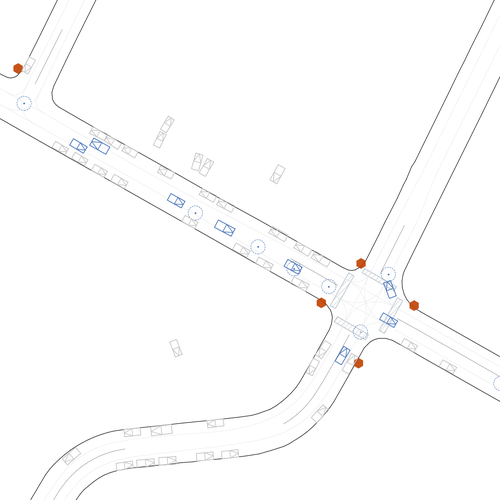
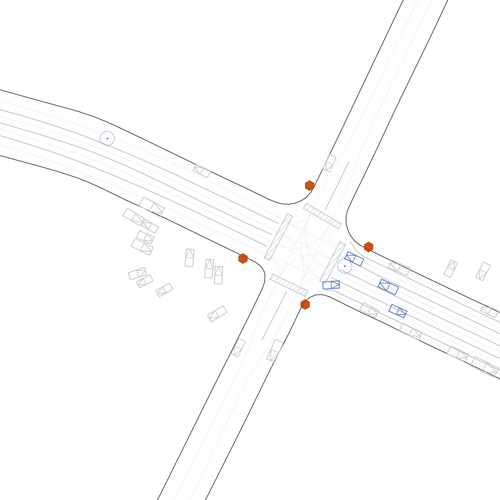

In [23]:
import mediapy
frames = get_frames(bc_policy)
mediapy.show_videos(frames, fps=5, width=500, height=500, columns=2, codec='gif')

In [19]:
bc_policy_NLL = Net(
    input_size=traj_data_loader.observation_space.shape[0], 
    hidden_size=800, 
    output_size=len(traj_data_loader.action_space)
).to(DEVICE)

In [12]:
from gpudrive.datatypes.roadgraph import LocalRoadGraphPoints

In [13]:
roadgraph = LocalRoadGraphPoints.from_tensor(
    local_roadgraph_tensor=env.sim.agent_roadmap_tensor(),
    backend=env.backend,
    device=env.device,
    mask=None,
)

In [ ]:
print(roadgraph.x[:, 0, 0] + env., roadgraph.x[:, 1, 1])

tensor([ 42.2871, -49.4741], device='cuda:0') tensor([-43.6705, -27.0564], device='cuda:0')
